In [1]:
import tensorflow as tf


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os

#all teh importing of fiole inception model will be used for transfer leanring 

In [3]:
data ='PetImages'

In [4]:
print("number of images in cats :",len(os.listdir('tmp/PetImages/Cat/')))
print("number of images in dogs :",len(os.listdir('tmp/PetImages/Dog/')))

number of images in cats : 12501
number of images in dogs : 12501


In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [29]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
    
    
 

In [33]:
cat_source="tmp/PetImages/Cat/"
dog_source="tmp/PetImages/Dog/"
training_cat="tmp/cats-v-dogs/training/cats/"
testing__cat="tmp/cats-v-dogs/testing/cats/"

training_dogs="tmp/cats-v-dogs/training/dogs/"
testing__dogs="tmp/cats-v-dogs/testing/dogs/"


In [34]:
split_size=.9
split_data(cat_source,training_cat,testing__cat,split_size)

666.jpg is zero length, so ignoring.


In [35]:
split_data(dog_source,training_dogs,testing__dogs,split_size)

11702.jpg is zero length, so ignoring.


In [36]:
print("training length of cat",len(os.listdir(training_cat)))
print("testing length of cat",len(os.listdir(testing__cat)))

print("training length of dogs",len(os.listdir(training_dogs)))
print("testing length dogs",len(os.listdir(testing__dogs)))

training length of cat 12357
testing length of cat 2357
training length of dogs 11250
testing length dogs 1250


In [37]:

# Image pe Data augmentation laga rhay hain



Training_dir="tmp/cats-v-dogs/training/"
train_datagen=ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(Training_dir,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 23605 images belonging to 2 classes.
Found 3607 images belonging to 2 classes.


In [39]:
import urllib.request
#downloading Model Inception weightsd
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x17ac6ceb550>)

In [40]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    print(layer)
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [41]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [43]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=2,
            verbose=1)

Epoch 1/2
183/237 [======================>.......] - ETA: 1:15 - loss: 0.4644 - acc: 0.8982

D:\anaconda\envs\fazal\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


237/237 [==============================] - 374s 2s/step - loss: 0.3956 - acc: 0.9064 - val_loss: 0.1023 - val_acc: 0.9606
Epoch 2/2
237/237 [==============================] - 270s 1s/step - loss: 0.1445 - acc: 0.9394 - val_loss: 0.0904 - val_acc: 0.9626


In [47]:
file_path="tmp/weights/"
model.save_weights(file_path)

<Figure size 640x480 with 0 Axes>

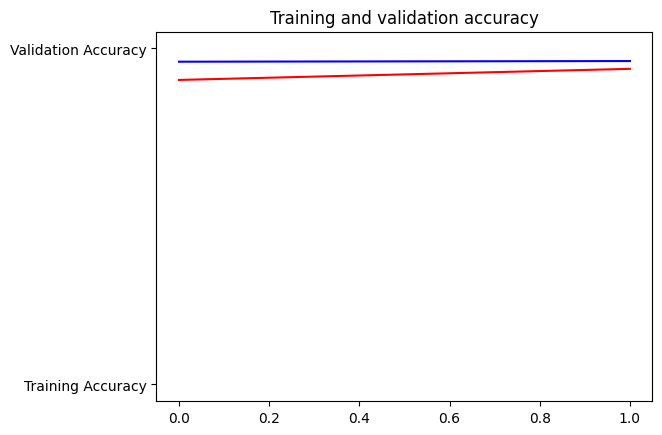

<Figure size 640x480 with 0 Axes>

In [48]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

In [49]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

ModuleNotFoundError: No module named 'google.colab'